In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    transcriptor, rev_comp, lbl2lbl_id, lbl_id2lbl, collapse_mutspec
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, _prepare_nice_labels, plot_mutspec96
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

sns.set_style()

In [2]:
df = pd.read_csv("~/Downloads/mutspec12AddedClusters.tsv", sep="\t", index_col=0)
df.head()

,Species,Mut,MutSpec,ObsNum,Cluster
110267,Abagrotis_alternata,A>C,0.000000,0.000000,0.0
110256,Abagrotis_alternata,A>G,0.039734,3.904703,0.0
110257,Abagrotis_alternata,A>T,0.893940,0.947695,0.0
110258,Abagrotis_alternata,C>A,0.066326,0.956128,0.0
110264,Abagrotis_alternata,C>G,0.000000,0.000000,0.0


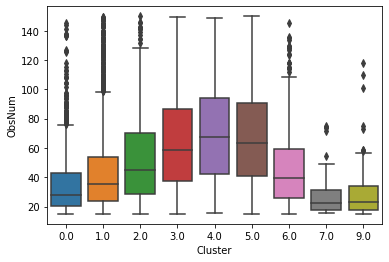

In [3]:
x = data=df.groupby(["Cluster", "Species"]).ObsNum.sum().reset_index()
sns.boxplot(data=x[x["ObsNum"] < 150], y="ObsNum", x="Cluster");

In [4]:
df.groupby("Cluster").Species.nunique()

Cluster
0.0    1045
1.0    2693
2.0     537
3.0    1558
4.0     434
5.0     447
6.0     458
7.0      68
9.0     175
Name: Species, dtype: int64

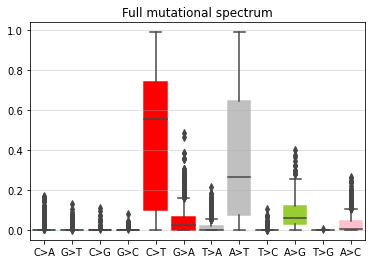

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [5]:
plot_mutspec12(df[df.Cluster == 0], style="box")

In [6]:
df[df.Cluster == 0].pivot("Species", "Mut", "ObsNum").sort_values("A>T")

Mut,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
Species,,,,,,,,,,,,
Idiocerus_obispanus,0.999981,4.986584,0.000000,0.0,0.0,8.956224,1.991014,0.0,0.991386,0.000000,6.980447,0.000000
Eucosma_tocullionana,0.000000,3.976370,0.000000,0.0,0.0,6.835149,0.976490,0.0,0.000000,1.999860,0.976465,0.999970
Eucereon_centrale,0.999988,1.979806,0.000000,0.0,0.0,3.975416,1.980498,0.0,0.000000,0.980980,6.862645,0.000000
Rhamphomyia_albopilosa,0.999959,10.829716,0.000000,0.0,0.0,1.978158,2.981671,0.0,0.000000,0.000000,4.908172,0.000000
Idaea_rusticata,0.000000,6.857928,0.000000,0.0,0.0,6.232114,0.000000,0.0,0.000000,0.976065,5.447070,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Eumerus_torsicus,2.754104,4.333519,25.008033,0.0,0.0,13.850430,0.999989,0.0,0.000000,26.076672,12.267272,0.000000
Anthophora_plumipes,1.993743,94.520372,26.479874,0.0,0.0,9.278554,39.850140,0.0,5.572114,17.075775,33.960895,8.603847
Mesembrius_strigilatus,1.718896,3.409617,26.774375,0.0,0.0,15.048497,1.684047,0.0,0.000000,23.410186,12.987778,0.000000
